In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
# Create labels for the x-axis (temperature ranges)

import sys
parent_dir = os.path.dirname(os.environ["GTE_DIR"].replace("Glaciation_time_estimator",""))
GTE_DIR=os.environ["GTE_DIR"]
sys.path.insert(0, parent_dir)
from Glaciation_time_estimator.Data_postprocessing.Job_result_fp_generator import generate_tracking_filenames
from Glaciation_time_estimator.Auxiliary_func.config_reader import read_config

In [2]:
from derivative import dxdt

Load data

In [ ]:
config = read_config(
    os.path.join(GTE_DIR,'/config_half.yaml'))
t_deltas = config['t_deltas']
agg_fact = config['agg_fact']
min_temp_array, max_temp_array = config['min_temp_arr'], config['max_temp_arr']
folder_name = f"{config['start_time'].strftime(config['time_folder_format'])}_{config['end_time'].strftime(config['time_folder_format'])}"

In [4]:
global_rmse=0.05628526744657018 
ice_cont_crit_frac = 0.05

In [5]:
def Extract_array_from_df(series: pd.Series):
    if series.empty:
        return None
    return np.stack(series.values)

In [6]:

# Initialize an empty list to store the individual dataframes
cloud_properties_df_list = []

# Iterate over each temperature range
for i in range(len(min_temp_array)):
    cloud_properties_df_list.append([])
    min_temp = min_temp_array[i]
    max_temp = max_temp_array[i]

    # Iterate over each pole
    for pole in config["pole_folders"]:
        # Construct the file path
        fp = os.path.join(
            config['postprocessing_output_dir'],
            pole,
            folder_name,
            f"Agg_{agg_fact:02}_T_{abs(round(min_temp)):02}_{abs(round(max_temp)):02}.parquet"
        )

        # Read the parquet file into a dataframe
        df = pd.read_parquet(fp)

        # Add columns for min_temp, max_temp, and pole
        df['min_temp'] = min_temp
        df['max_temp'] = max_temp
        df['pole'] = pole
        df['Hemisphere'] = "South" if pole == "sp" else "North"
        df['Lifetime [h]'] = df['track_length'] / pd.Timedelta(hours=1)

        # Append the dataframe to the sublist
        cloud_properties_df_list[i].append(df)

# Combine all dataframes into a single dataframe
combined_df = pd.concat(
    [df for sublist in cloud_properties_df_list for df in sublist], ignore_index=True)

In [7]:
def normalize_IF_hist(row):
    lst = row['ice_frac_hist']
    normalized_length = 100
    original_indices = np.linspace(0, 1, len(lst))
    target_indices = np.linspace(0, 1, normalized_length)
    return np.interp(target_indices, original_indices, lst)


def max_normalize_IF_hist(row):
    lst = row['ice_frac_hist']
    max_val = np.max(lst)
    normalized_length = 100
    if max_val == 0:
        normalized_list = np.zeros(normalized_length)
        max_idx = None
    else:
        max_idx = np.argmax(lst)
        original_indices = np.linspace(0, max_idx, len(lst[:max_idx + 1]))
        target_indices = np.linspace(0, max_idx, normalized_length)
        normalized_list = np.interp(
            target_indices, original_indices, lst[:max_idx + 1])
        normalized_list = np.pad(
            normalized_list, (0, normalized_length - len(normalized_list)), constant_values=np.nan)
    return normalized_list, max_idx

In [8]:
norm_IF_hist_list = []
max_norm_IF_hist_list = []
Timesteps_to_max_list = []
for i, row in combined_df.iterrows():
    if i % 10000 == 0:
        print(i/10000)
    max_norm_IF_hist, Timesteps_to_max = max_normalize_IF_hist(row)
    norm_IF_hist_list.append(normalize_IF_hist(row))
    max_norm_IF_hist_list.append(max_norm_IF_hist)
    Timesteps_to_max_list.append(Timesteps_to_max)
combined_df["Timesteps_to_max"] = Timesteps_to_max_list
combined_df['max_norm_IF_hist'] = max_norm_IF_hist_list
combined_df['norm_IF_hist'] = norm_IF_hist_list

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0


Load data

In [9]:
def Extract_array_from_df(series: pd.Series):
    if series.empty:
        return None
    return np.stack(series.values)

In [10]:
cloud_properties_df_list = []
for i in range(len(min_temp_array)):
    cloud_properties_df_list.append([])
    min_temp = min_temp_array[i]
    max_temp = max_temp_array[i]
    for pole in config["pole_folders"]:
        fp = os.path.join(config['postprocessing_output_dir'], pole, folder_name,
                          f"Agg_{agg_fact:02}_T_{abs(round(min_temp)):02}_{abs(round(max_temp)):02}.parquet")
        cloud_properties_df_list[i].append(pd.read_parquet(fp))

Spaghetti plots

In [11]:
def check_cloud(row, params):
    norm_ice_frac_hist = row['norm_IF_hist']
    if (max(norm_ice_frac_hist) >= params['crit_max_IF']) and row['Timesteps_to_max'] >= params['min_time_to_max'] and row['track_length'] >= params['crit_lifetime'] and (max(norm_ice_frac_hist) >= norm_ice_frac_hist[:10].mean()+params['min_delta_IF']):
        return True
    return False

In [12]:
sample_df = combined_df.sample(10, random_state=0)

In [13]:
sample_df["Lifetime [h]"].idxmax()


229152

In [14]:
class Peak:
    def __init__(self, startidx):
        self.born = self.left = self.right = startidx
        self.died = None

    def get_persistence(self, seq):
        return float("inf") if self.died is None else seq[self.born] - seq[self.died]


def get_persistent_homology(seq):
    peaks = []
    # Maps indices to peaks
    idxtopeak = [None for s in seq]
    # Sequence indices sorted by values
    indices = range(len(seq))
    indices = sorted(indices, key=lambda i: seq[i], reverse=True)

    # Process each sample in descending order
    for idx in indices:
        lftdone = (idx > 0 and idxtopeak[idx-1] is not None)
        rgtdone = (idx < len(seq)-1 and idxtopeak[idx+1] is not None)
        il = idxtopeak[idx-1] if lftdone else None
        ir = idxtopeak[idx+1] if rgtdone else None

        # New peak born
        if not lftdone and not rgtdone:
            peaks.append(Peak(idx))
            idxtopeak[idx] = len(peaks)-1

        # Directly merge to next peak left
        if lftdone and not rgtdone:
            peaks[il].right += 1
            idxtopeak[idx] = il

        # Directly merge to next peak right
        if not lftdone and rgtdone:
            peaks[ir].left -= 1
            idxtopeak[idx] = ir


        # Merge left and right peaks
        if lftdone and rgtdone:
            # Left was born earlier: merge right to left
            if seq[peaks[il].born] > seq[peaks[ir].born]:
                peaks[ir].died = idx
                peaks[il].right = peaks[ir].right
                idxtopeak[peaks[il].right] = idxtopeak[idx] = il
            else:
                peaks[il].died = idx
                peaks[ir].left = peaks[il].left
                idxtopeak[peaks[ir].left] = idxtopeak[idx] = ir

    # This is optional convenience
    # return sorted(peaks, key=lambda p: p.get_persistence(seq), reverse=True)
    # return idxtopeak, sorted(peaks, key=lambda p: -p.born, reverse=True)
    return peaks

In [15]:
from scipy.signal import savgol_filter
from scipy.ndimage import uniform_filter1d


def noise_filter(row, w=3):
    IF_hist = np.array(row['ice_frac_hist'])
    conv_arr = np.ones(w)/w
    return np.convolve(IF_hist, conv_arr, mode='valid')


# def noise_filter_2(row, w=3):
#     return row['ice_frac_hist'].rolling(window= 3).mean()


def noise_filter_3(row, w=3):
    IF_hist = np.array(row['ice_frac_hist'])
    return uniform_filter1d(IF_hist, size=w, mode='nearest')


def noise_filter_4(row, w=4, order=2):
    IF_hist = np.array(row['ice_frac_hist'])
    return savgol_filter(IF_hist, w, order)

[ 6.66666667e-02  1.66666667e-01  1.66666667e-01  2.33333333e-01
  3.33333333e-01  4.00000000e-01  2.66666667e-01  6.66666667e-02
 -1.85037171e-17]


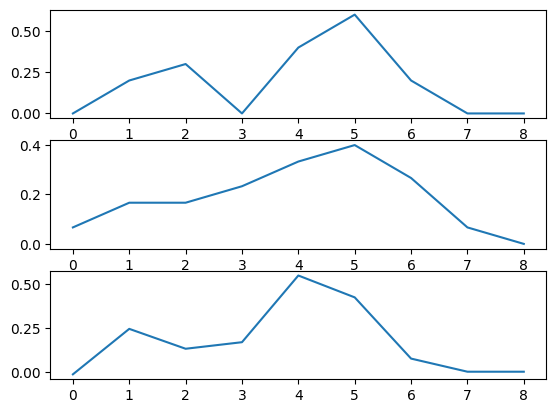

In [16]:
custom_sample = sample_df.iloc[1].copy()
custom_sample['ice_frac_hist'] = np.array(
    [0, 0.2, 0.3, 0.0, 0.4, 0.6, 0.2, 0.0, 0.0])
fig, ax = plt.subplots(3, 1)
ax[0].plot(custom_sample['ice_frac_hist'])
filtered = noise_filter_3(custom_sample)
ax[1].plot(filtered)
ax[2].plot(noise_filter_4(custom_sample))
print(filtered)
plt.show()

# plt.plot(np.arange(len(test_sample['ice_frac_hist'])),noise_filter(test_sample))

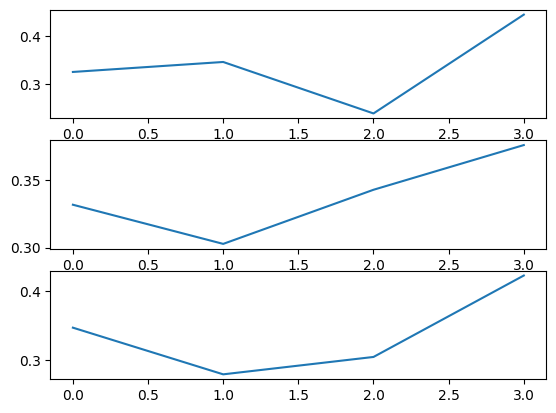

In [17]:
fig, ax = plt.subplots(3, 1)
# 229152
# 195006
test_sample = sample_df.loc[195006]
ax[0].plot(test_sample["ice_frac_hist"])
ax[1].plot(noise_filter_3(test_sample))
ax[2].plot(noise_filter_4(test_sample))
# ax[1].plot(filtered)

Importnant samples 229152, 195006

Test cases

In [18]:
n_test_hist = 4
error_delta = 0.1
test_IF_hist = [None for i in range(n_test_hist)]
test_hist_labels = [None for i in range(n_test_hist)]

 - Slow rise

In [19]:
np.random.seed(1)
n_rise = 60
n_descend = 8
slow_rise = np.linspace(0.2, 0.62, n_rise) + \
    (np.random.rand(n_rise)-0.5)*error_delta
sharp_descend = np.linspace(0.65, 0.4, n_descend) + \
    np.random.rand(n_descend)*error_delta*2
test_IF_hist[0] = list(np.concatenate((slow_rise, sharp_descend)))
test_hist_labels[0] = "Slow glaciation"
# plt.plot(test_IF_hist[0])

 - Minor and major peak

In [20]:
np.random.seed(2)
# Parameters for the bell curve
mean = [0]  # Center of the bell curve
std_dev = 2  # Spread of the curve (standard deviation)
n_bell_points = 10  # Number of points in the list

# Generate x values and corresponding y values for the bell curve


def gen_bell_curve(mean, std_dev, n_bell_points):
    x_values = np.linspace(-3 * std_dev, 3 * std_dev, n_bell_points)
    return (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_values - mean) / std_dev) ** 2)


# Convert the curve to a list
small_bell_curve = gen_bell_curve(mean, std_dev, n_bell_points)
small_bell_curve = small_bell_curve[:-int(n_bell_points/4)]
big_bell_curve = gen_bell_curve(mean, std_dev*2, n_bell_points*2)*5
big_bell_curve = big_bell_curve[big_bell_curve > small_bell_curve[-1]]
combined_curve = np.concatenate((small_bell_curve, big_bell_curve))
combined_curve += np.random.rand(len(combined_curve))*error_delta*2
combined_curve[combined_curve < 0] = 0
test_IF_hist[1] = list(combined_curve)
test_hist_labels[1] = "Minor peak prior to glaciation"
# plt.plot(test_IF_hist[1])

 - Two glaciations

 - Real cases

In [21]:
test_IF_hist[2] = combined_df.loc[229152]['ice_frac_hist']
test_hist_labels[2] = "Real case 1 - Large cloud"
test_IF_hist[3] = combined_df.loc[192471]['ice_frac_hist']
test_hist_labels[3] = "Real case 2 - Quick glaciation"

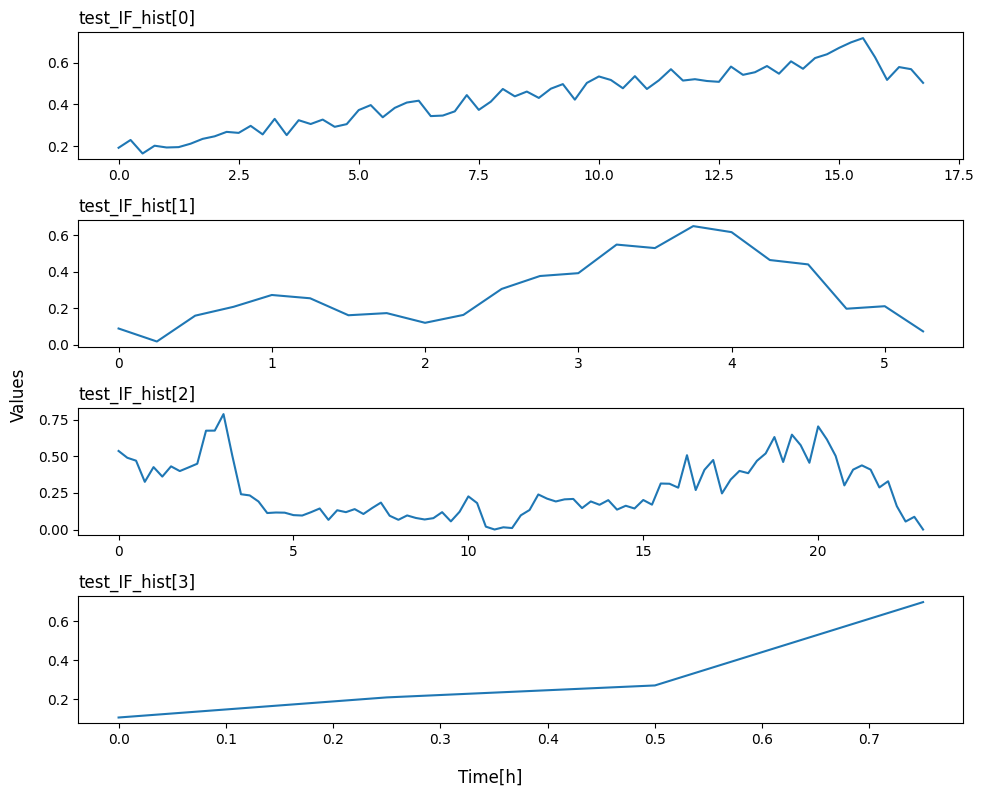

In [22]:
num_subplots = len(test_IF_hist)
# Create a figure and subplots
fig, axes = plt.subplots(
    num_subplots, 1, figsize=(10, 2 * num_subplots), sharex=False)

# Ensure axes is iterable (in case of a single subplot)
if num_subplots == 1:
    axes = [axes]

# Plot each list in a subplot
for idx, data in enumerate(test_IF_hist):
    x_values = [i * 0.25 for i in range(len(data))]  # Scale x-axis by 0.25
    axes[idx].plot(x_values, data)  # Adjust the plot style as needed
    axes[idx].set_title(f"test_IF_hist[{idx}]", loc='left')

# Set common labels
fig.supylabel("Values")
fig.supxlabel("Time[h]")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [23]:
tests_df = pd.DataFrame(
    {'ice_frac_hist': test_IF_hist, 'label': test_hist_labels})

Measure noise mse in data

In [24]:
filtered_df = combined_df[(combined_df["max_ice_fraction"] - (1-combined_df["max_water_frac"])>=0.3) & (combined_df["Lifetime [h]"]>=2)]
len(filtered_df)

12199

\sqrt{MSE} rel to Sav. Gol. fit: 0.05628526744657018 (window 5 , order 2) \
\sqrt{MSE} rel to Moving mean fit: 0.08558692241683627 (window 5) \
\sqrt{MSE} rel to Moving mean fit: 0.0669063429943993 (window 3)

In [25]:
se_sum=0
sample_count=0
for i, row in filtered_df.iterrows():
    data = np.array(row['ice_frac_hist'])
    filt_data = noise_filter_3(row, w=3)
    #filt_data = savgol_filter(data, window_length=5, polyorder=2)
    first_estimate=0.1
    meas_idx = (data<1-first_estimate) & (data>first_estimate)
    se_sum += (np.square(data[meas_idx] - filt_data[meas_idx])).sum()
    sample_count+=len(data[meas_idx])
print(np.sqrt(se_sum/sample_count))

0.0669063429943993


In [26]:
from scipy.integrate import cumulative_trapezoid
class Glaciation:
    def __init__(self, min_ind, max_ind, data, timestep=15):
        self.max = data[max_ind]
        self.min = data[min_ind]
        self.min_ind = min_ind
        self.max_ind = max_ind
        self.magnitude = self.max - self.min
        self.timestep=timestep
        self.time = (max_ind - min_ind)*timestep
    # def find_nearest_peak(self,filtered_data,target_peak):
    #     if peak.born == 0:
    #         return Peak(0)
    #     else:
    #         peaks = get_persistent_homology(filtered_data)
    #         max_persistance = 0
    #         max_persistance_peak = 0
    #         start_search_ind=0
    #         for peak in peaks:
    #             if peak.born > target_peak.born-60//self.timestep and peak.born < target_peak.born+60//self.timestep:
    #                 peak.get_persistence(filtered_data)
    def estimate_glac_time(self,data ,max_rmse_diff=2 ):
        glac_timesteps=self.max_ind- self.min_ind
        if glac_timesteps ==1:
            self.linear=True
            time=self.timestep
            self.rate_arr=np.array([(self.max-self.min)/self.timestep*60])
            self.line_rmse=0
        else:
            #Calculate mean suqared error relative to a line between the two points
            linear_growth_line = np.linspace(data[self.min_ind],data[self.max_ind], num =glac_timesteps+1 )
            rmse = np.sqrt((np.square(linear_growth_line - data[self.min_ind:self.max_ind+1])).mean())
            self.line_rmse=rmse
            if rmse>max_rmse_diff*global_rmse:
                self.linear=False
                #This divide by 3 is the magic number that makes all the noise robust derivatives work
                magical_factor=3
                t=np.arange(len(data))/magical_factor
                #TODO: Correct min and max ind to min and max in filtered data
                dIFdt = dxdt(data, t, kind="trend_filtered", order=0, alpha=1e-2)
                trend_filtered_curve = data[0] + cumulative_trapezoid(dIFdt, t, initial=0)
                # self.find_nearest_peak(trend_filtered_curve)
                #Correct so that total delta is equal to measured magnitude
                dIFdt_glac = dIFdt[self.min_ind:self.max_ind+1]
                dIFdt_glac *= self.magnitude/(cumulative_trapezoid(dIFdt_glac, t[self.min_ind:self.max_ind+1], initial=0)[-1])

                #Factor *4/3 added: 4 to convert to hours  and 3 to correct for the factor added above
                dIFdt_glac *= 60/self.timestep/magical_factor
                #Not sure about min rate to take
                self.rate_arr=dIFdt_glac[dIFdt_glac>1e-2]
                # print(f"rmse = {rmse:03f}: Non-linear")
            else:
                # print(f"rmse = {rmse:03f}: Linear")
                self.linear=True
                self.rate_arr=np.full(glac_timesteps , (self.max-self.min)/(glac_timesteps*self.timestep)*60)
        self.avg_rate = self.rate_arr.mean()
        
def select_peaks(data, filt, significant_peak_tresh=0.2, glac_tresh=0.4, return_filt=True):
    if filt is not None:
        filt_data = np.array(filt(data))
    else:
        filt_data = np.array(data)
    peaks = get_persistent_homology(filt_data)
    prev_peak = Peak(0)
    glac_list = []
    for peak in peaks:
        if peak.born > prev_peak.born+1:
            if peak.get_persistence(filt_data) >= significant_peak_tresh:
                # local_min = data[prev_peak.born:peak.born].min()
                # print(f"{prev_peak.born},{peak.born}")
                inter_peak_data = filt_data[prev_peak.born:peak.born]
                local_min_ind = np.where(
                    inter_peak_data == inter_peak_data.min())[0][-1]
                local_min = inter_peak_data[local_min_ind]
                if filt_data[peak.born] - local_min >= glac_tresh:
                    glac_list.append(Glaciation(
                        prev_peak.born + local_min_ind, peak.born, filt_data))
                prev_peak = peak
    if return_filt:
        return filt_data, glac_list
    return glac_list

In [27]:
for i, row in tests_df.iterrows():
    print(f"{row['label']}:")
    x = np.array(row['ice_frac_hist'])
    filt_data, glac_list = select_peaks(x,None)
    for glac in glac_list:     
        glac.estimate_glac_time(x)
        print(glac.rate_arr)


Slow glaciation:
[0.03688018 0.03688018 0.03688018 0.03688018 0.03688018 0.03688018
 0.03688018 0.03688018 0.03688018 0.03688018 0.03688018 0.03688018
 0.03688018 0.03688018 0.03688018 0.03688018 0.03688018 0.03688018
 0.03688018 0.03688018 0.03688018 0.03688018 0.03688018 0.03688018
 0.03688018 0.03688018 0.03688018 0.03688018 0.03688018 0.03688018
 0.03688018 0.03688018 0.03688018 0.03688018 0.03688018 0.03688018
 0.03688018 0.03688018 0.03688018 0.03688018 0.03688018 0.03688018
 0.03688018 0.03688018 0.03688018 0.03688018 0.03688018 0.03688018
 0.03688018 0.03688018 0.03688018 0.03688018 0.03688018 0.03688018
 0.03688018 0.03688018 0.03688018 0.03688018 0.03688018 0.03688018]
Minor peak prior to glaciation:
[0.16384296 0.16384296 0.16384296 0.02474968 0.35233241 0.35233241
 0.35233241 0.35233241 0.35233241 0.35233241 0.2709151 ]
Real case 1 - Large cloud:
[0.2054473 0.2054473 0.2054473 0.2054473 0.2054473 0.2054473 0.2054473
 0.2054473 0.2054473]
[0.07606349 0.07606349 0.07606349 0.

In [28]:
# def test_func(test_df, funcs, func_labels=None):
#     num_subplots = len(test_df)*(len(funcs)+1)
#     # Create a figure and subplots

#     fig, axes = plt.subplots(
#         num_subplots, 1, figsize=(10, 2.5 * num_subplots), sharex=True)
#     # Ensure axes is iterable (in case of a single subplot)
#     if num_subplots == 1:
#         axes = [axes]
#     for idx, row in test_df.iterrows():
#         data = row['ice_frac_hist']
#         #x_values = [i * 0.25 for i in range(len(data))]  # Scale x-axis by 0.25
#         x_values = [i for i in range(len(data))]  # Scale x-axis by 0.25
#         # Adjust the plot style as needed
#         axes[idx*len(funcs)+idx].plot(x_values, data)
#         axes[idx*len(funcs)+idx].set_title(f"{row['label']}", loc='left')
#         # print(idx*len(funcs)+idx)
#         for func_idx, func in enumerate(funcs):
#             filtered_hist, glaciations = func(row)
#             # print(idx*len(funcs)+func_idx+idx+1)
#             # Adjust the plot style as needed
#             ax_ind = idx*len(funcs)+func_idx+idx+1
#             axes[ax_ind].plot(x_values, filtered_hist)
#             if func_labels is not None:
#                 axes[ax_ind].set_title(
#                     f"{func_labels[func_idx]} applied on {row['label']}", loc='left')
#             else:
#                 axes[ax_ind].set_title(
#                     f"Test func {func_idx} applied on {row['label']}", loc='left')
#             if len(glaciations)!=0:
#                 # min_ind = [glac.min_ind  for glac in glaciations]
#                 # max_ind = [glac.max_ind for glac in glaciations]
#                 # axes[ax_ind].scatter(min_ind, [glac.min for glac in glaciations], color='blue')
#                 # axes[ax_ind].scatter(max_ind, [glac.max for glac in glaciations], color='red')
#                 # for glac in glaciations:
#                 #     x_coord = glac.max_ind
#                 #     y_coord = filtered_hist[x_coord]
#                 #     axes[ax_ind].text(x_coord, y_coord, f'{glac.magnitude:.2f}',
#                 #             fontsize=8, color='blue', ha='right')
#                 for glac in glaciations:
#                     axes[ax_ind].axvspan(xmin=glac.min_ind, xmax=glac.max_ind, facecolor='green', alpha=0.3)
#     plt.tight_layout()

In [29]:
sample_df_2 = combined_df.sample(10, random_state=2)

In [30]:
len(combined_df[combined_df["max_ice_fraction"]-(1-combined_df["max_water_frac"])>0.9])/len(combined_df)*100

1.041734122512768

In [31]:
sample_df_3 = combined_df.sample(1000, random_state=2)
sample_df_3 = sample_df_3[sample_df_3["max_ice_fraction"]>0.1]
sample_df_3 = sample_df_3[sample_df_3["max_ice_fraction"]-(1-sample_df_3["max_water_frac"])>0.9]
len(sample_df_3)

10

/cluster/work/climate/dnikolo/flex_trkr_2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.072e-05, tolerance: 1.269e-05
  model = cd_fast.enet_coordinate_descent(
/cluster/work/climate/dnikolo/flex_trkr_2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.228e-01, tolerance: 5.294e-04
  model = cd_fast.enet_coordinate_descent(


Text(0.5, 0.98, 'Filtered test cases')

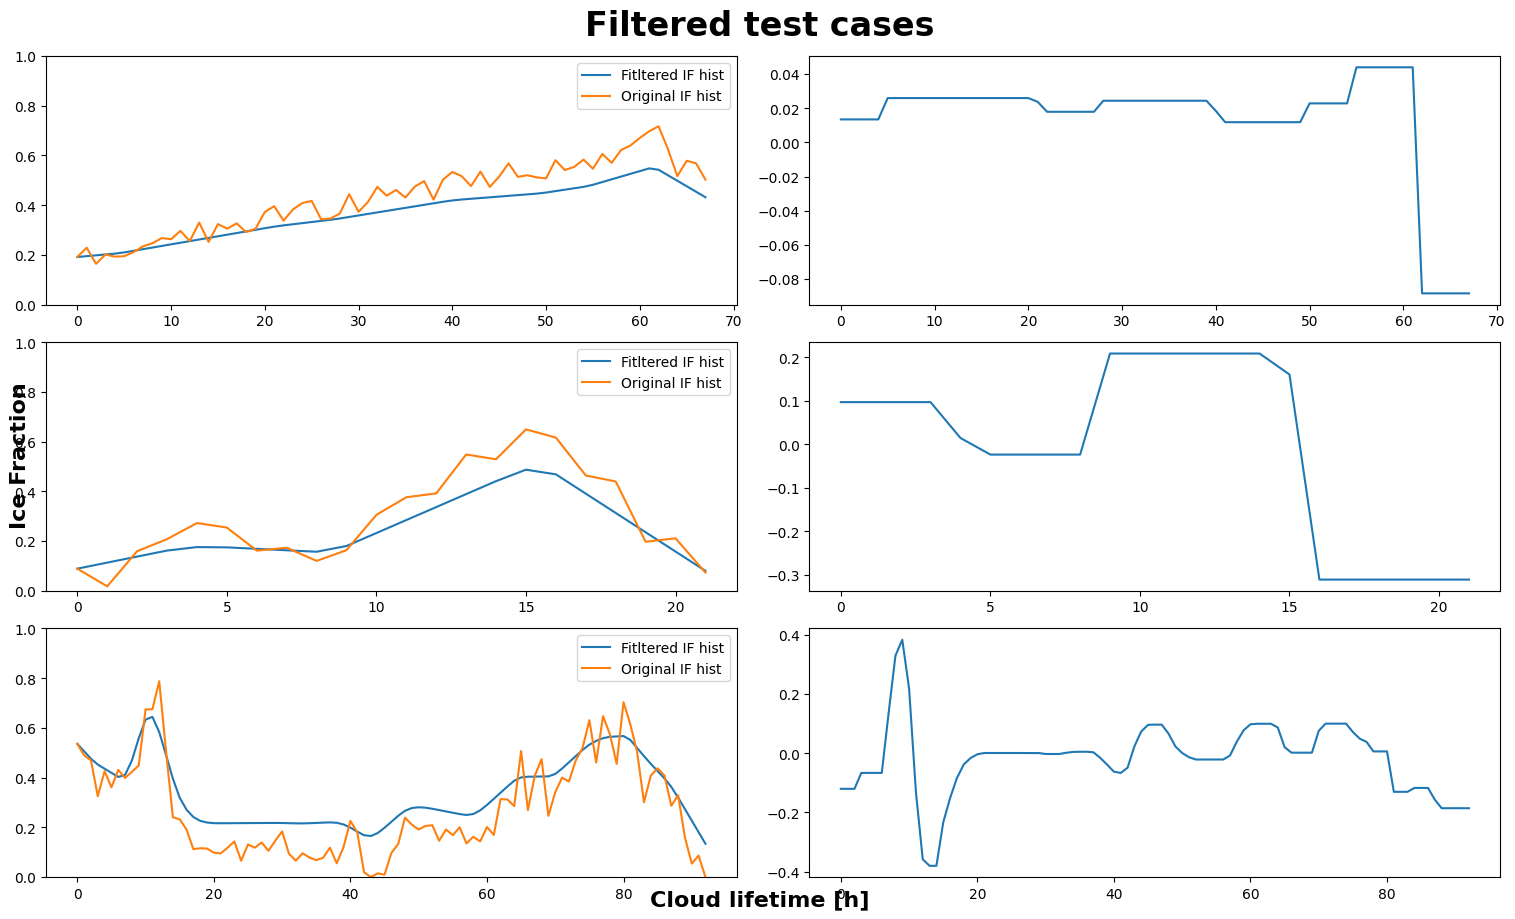

In [32]:
from scipy.integrate import cumulative_trapezoid
plot_df = tests_df.iloc[:-1]
fig, axes = plt.subplots(len(plot_df), 2,figsize=(15,3*len(plot_df)), constrained_layout=True)
i=0
for _, row in plot_df.iterrows():
    
    x=np.array(row['ice_frac_hist'])
    t = np.arange(len(x))/3
    # result6 = dxdt(x, t, kind="kalman", alpha=0.07)
    # result6 = dxdt(x, t, kind="kernel", sigma=1, lmbd=.1, kernel="rbf")
    result6 = dxdt(x, t, kind="trend_filtered", order=0, alpha=1e-2)

    t=np.arange(len(x))*0.25
    # axes[i][0].set_ylim(0,1)
    axes[i][0].plot(cumulative_trapezoid(result6, t, initial=0)+x[0], label="Fitltered IF hist")
    axes[i][0].plot(x,label="Original IF hist")
    axes[i][0].legend(fontsize=10)
    
    axes[i][1].plot(result6)
    axes[i][0].set_ylim(0,1)
    # axes[i][0].set_xlim(0,25)
    # axes[i][1].set_xlim(0,25)
    axes[i][0].tick_params(axis='both', which='major', labelsize=10)
    axes[i][0].tick_params(axis='both', which='minor', labelsize=8)
    axes[i][1].tick_params(axis='both', which='major', labelsize=10)
    axes[i][1].tick_params(axis='both', which='minor', labelsize=8)
    i+=1
# Add a common x-axis label
fig.text(0.5, 0, "Cloud lifetime [h]", ha='center',
            fontsize=16, fontweight='bold')

# Add a common y-axis label
fig.text(0, 0.5, "Ice Fraction", va='center',
            rotation='vertical', fontsize=16, fontweight='bold')
            
fig.suptitle('Filtered test cases', fontsize=24, fontweight='bold')

/cluster/work/climate/dnikolo/flex_trkr_2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.964e-04, tolerance: 1.819e-04
  model = cd_fast.enet_coordinate_descent(
/cluster/work/climate/dnikolo/flex_trkr_2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.777e-01, tolerance: 2.560e-04
  model = cd_fast.enet_coordinate_descent(
/cluster/work/climate/dnikolo/dump/ipykernel_2711332/3027099294.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


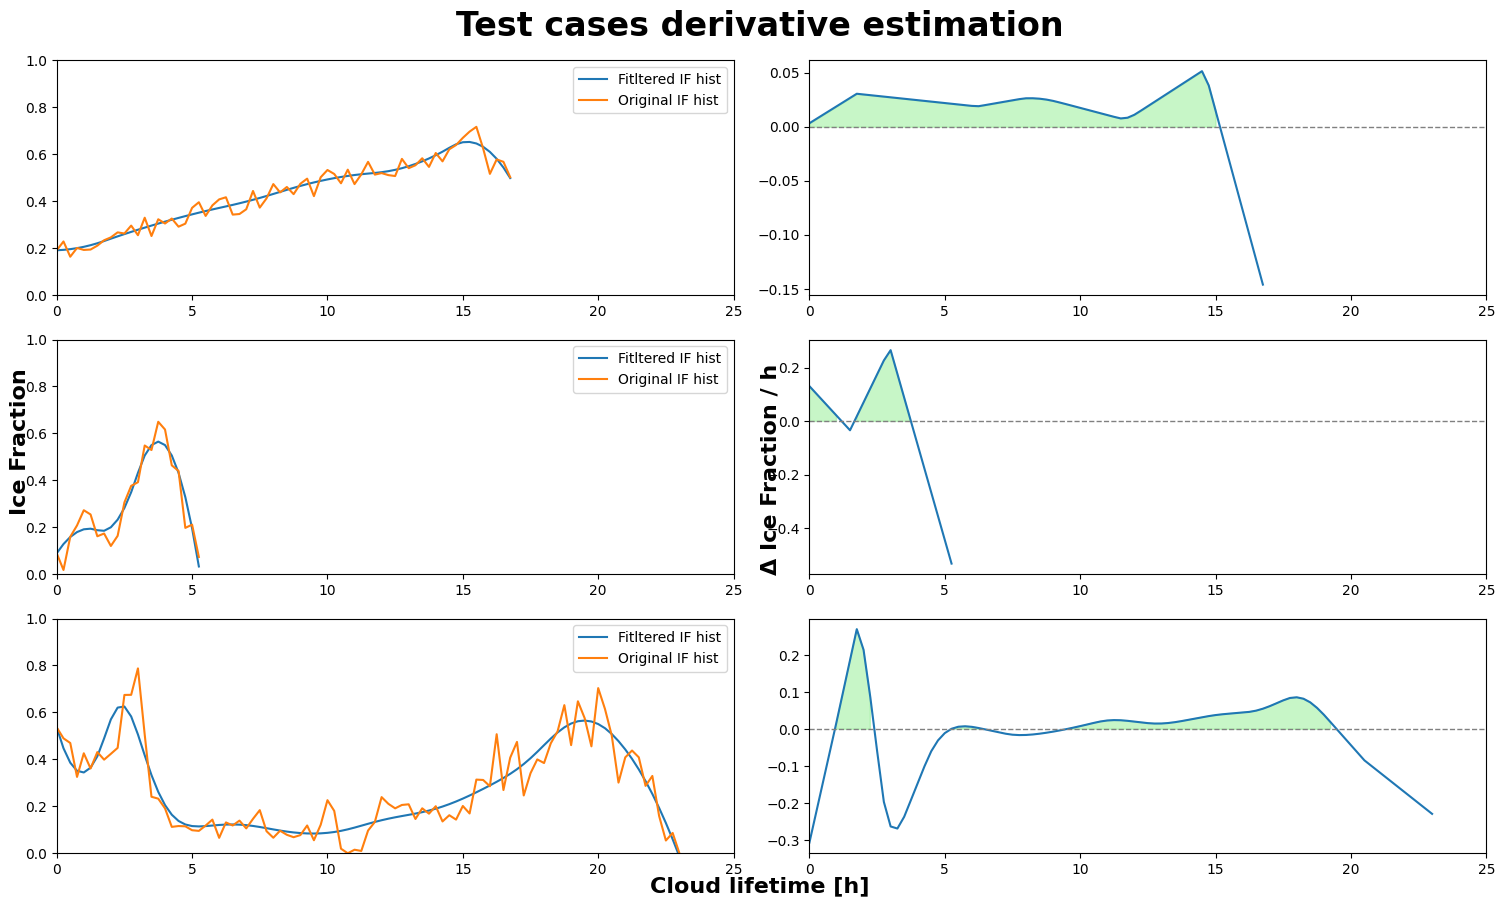

In [ ]:
from scipy.integrate import cumulative_trapezoid
plot_df = tests_df.iloc[:-1]
fig, axes = plt.subplots(len(plot_df), 2,figsize=(15,3*len(plot_df)), constrained_layout=True)
i=0
for _, row in plot_df.iterrows():
    
    x=np.array(row['ice_frac_hist'])
    t = np.arange(len(x))/3
    # result6 = dxdt(x, t, kind="kalman", alpha=0.07)
    #result6 = dxdt(x, t, kind="kernel", sigma=1, lmbd=.1, kernel="rbf")
    result6 = dxdt(x, t, kind="trend_filtered", order=1, alpha=1e-2)

    t_plot=np.arange(len(x))*0.25
    axes[i][0].set_ylim(0,1)
    axes[i][0].plot(t_plot,cumulative_trapezoid(result6, t, initial=0)+x[0], label="Fitltered IF hist")
    axes[i][0].plot(t_plot,x,label="Original IF hist")
    axes[i][0].legend(fontsize=10)
    axes[i][0].set_ylim(0,1)
    axes[i][1].plot(t_plot,result6)
    axes[i][1].fill_between(t_plot, result6, where=(result6 > 0), color='lightgreen', alpha=0.5, label="Positive values")
    axes[i][1].axhline(0, color='gray', linestyle='--', linewidth=1)  # Add dashed horizontal line

    # axes[i][1].fill_between(t_plot, result6, where=(result6 < 0), color='red', alpha=0.5, label="Area")
    axes[i][0].set_xlim(0,25)
    axes[i][1].set_xlim(0,25)
    axes[i][0].tick_params(axis='both', which='major', labelsize=10)
    axes[i][0].tick_params(axis='both', which='minor', labelsize=8)
    axes[i][1].tick_params(axis='both', which='major', labelsize=10)
    axes[i][1].tick_params(axis='both', which='minor', labelsize=8)
    i+=1
# Add a common x-axis label
fig.text(0.5, 0, "Cloud lifetime [h]", ha='center',
            fontsize=16, fontweight='bold')

# Add a common y-axis label
fig.text(0, 0.5, "Ice Fraction", va='center',
            rotation='vertical', fontsize=16, fontweight='bold')
fig.text(0.5, 0.47, "Δ Ice Fraction / h", va='center',
            rotation='vertical', fontsize=16, fontweight='bold')
fig.suptitle('Test cases derivative estimation', fontsize=24, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(GTE_DIR,"/Result_graphs/Derivative_estimation.png"),dpi=400)


/cluster/work/climate/dnikolo/flex_trkr_2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.072e-05, tolerance: 1.269e-05
  model = cd_fast.enet_coordinate_descent(


TypeError: 'Axes' object is not subscriptable

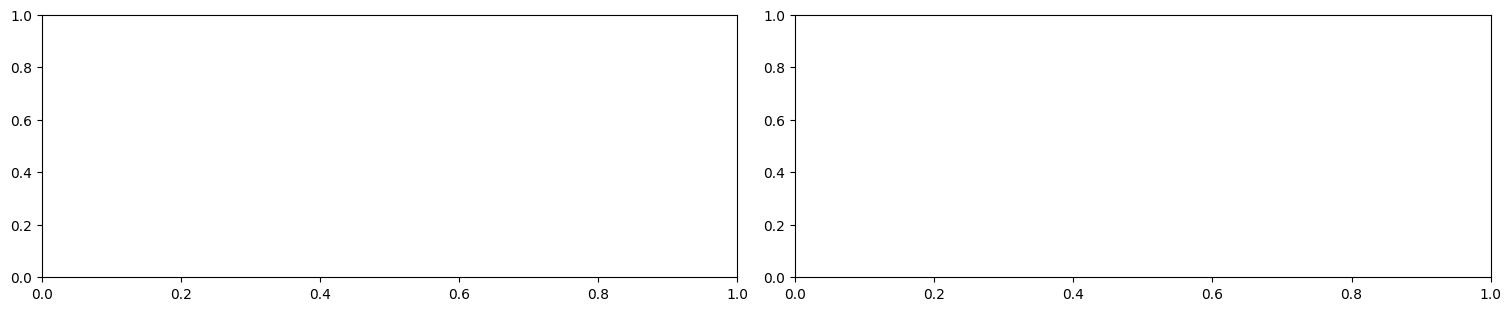

In [ ]:
from scipy.integrate import cumulative_trapezoid
plot_df = tests_df.iloc[:-1]
fig, axes = plt.subplots(int(len(plot_df)/2), 2,figsize=(15,3*int(len(plot_df)/2)), constrained_layout=True)
i=0
count=0
j=0
for _, row in plot_df.iterrows():
    j=count%2
    i=int(count/2)
    x=np.array(row['ice_frac_hist'])
    t = np.arange(len(x))/3
    # result6 = dxdt(x, t, kind="kalman", alpha=0.07)
    #result6 = dxdt(x, t, kind="kernel", sigma=1, lmbd=.1, kernel="rbf")
    result6 = dxdt(x, t, kind="trend_filtered", order=0, alpha=1e-2)


    # axes[i][j].plot(cumulative_trapezoid(result6, t, initial=0)+x[0], label="Fitltered IF hist")
    t=np.arange(len(x))*0.25
    axes[i][j].plot(t,x,label="Original IF hist")
    # axes[i][0].legend(fontsize=10)
    axes[i][j].set_ylim(0,1)
    axes[i][j].set_xlim(0,25)
    axes[i][j].tick_params(axis='both', which='major', labelsize=10)
    axes[i][j].tick_params(axis='both', which='minor', labelsize=8)
    axes[i][j].set_title(row['label'])
    # axes[i][1].plot(result6)
    
    count+=1
# Add a common x-axis label
fig.text(0.5, 0, "Cloud lifetime [h]", ha='center',
            fontsize=16, fontweight='bold')

# Add a common y-axis label
fig.text(0, 0.5, "Ice Fraction", va='center',
            rotation='vertical', fontsize=16, fontweight='bold')
            
fig.suptitle('Non-mathematical test cases', fontsize=24, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(GTE_DIR,"/Result_graphs/Non_mathematical_tests.png"),dpi=400)

/cluster/work/climate/dnikolo/flex_trkr_2/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.228e-01, tolerance: 5.294e-04
  model = cd_fast.enet_coordinate_descent(


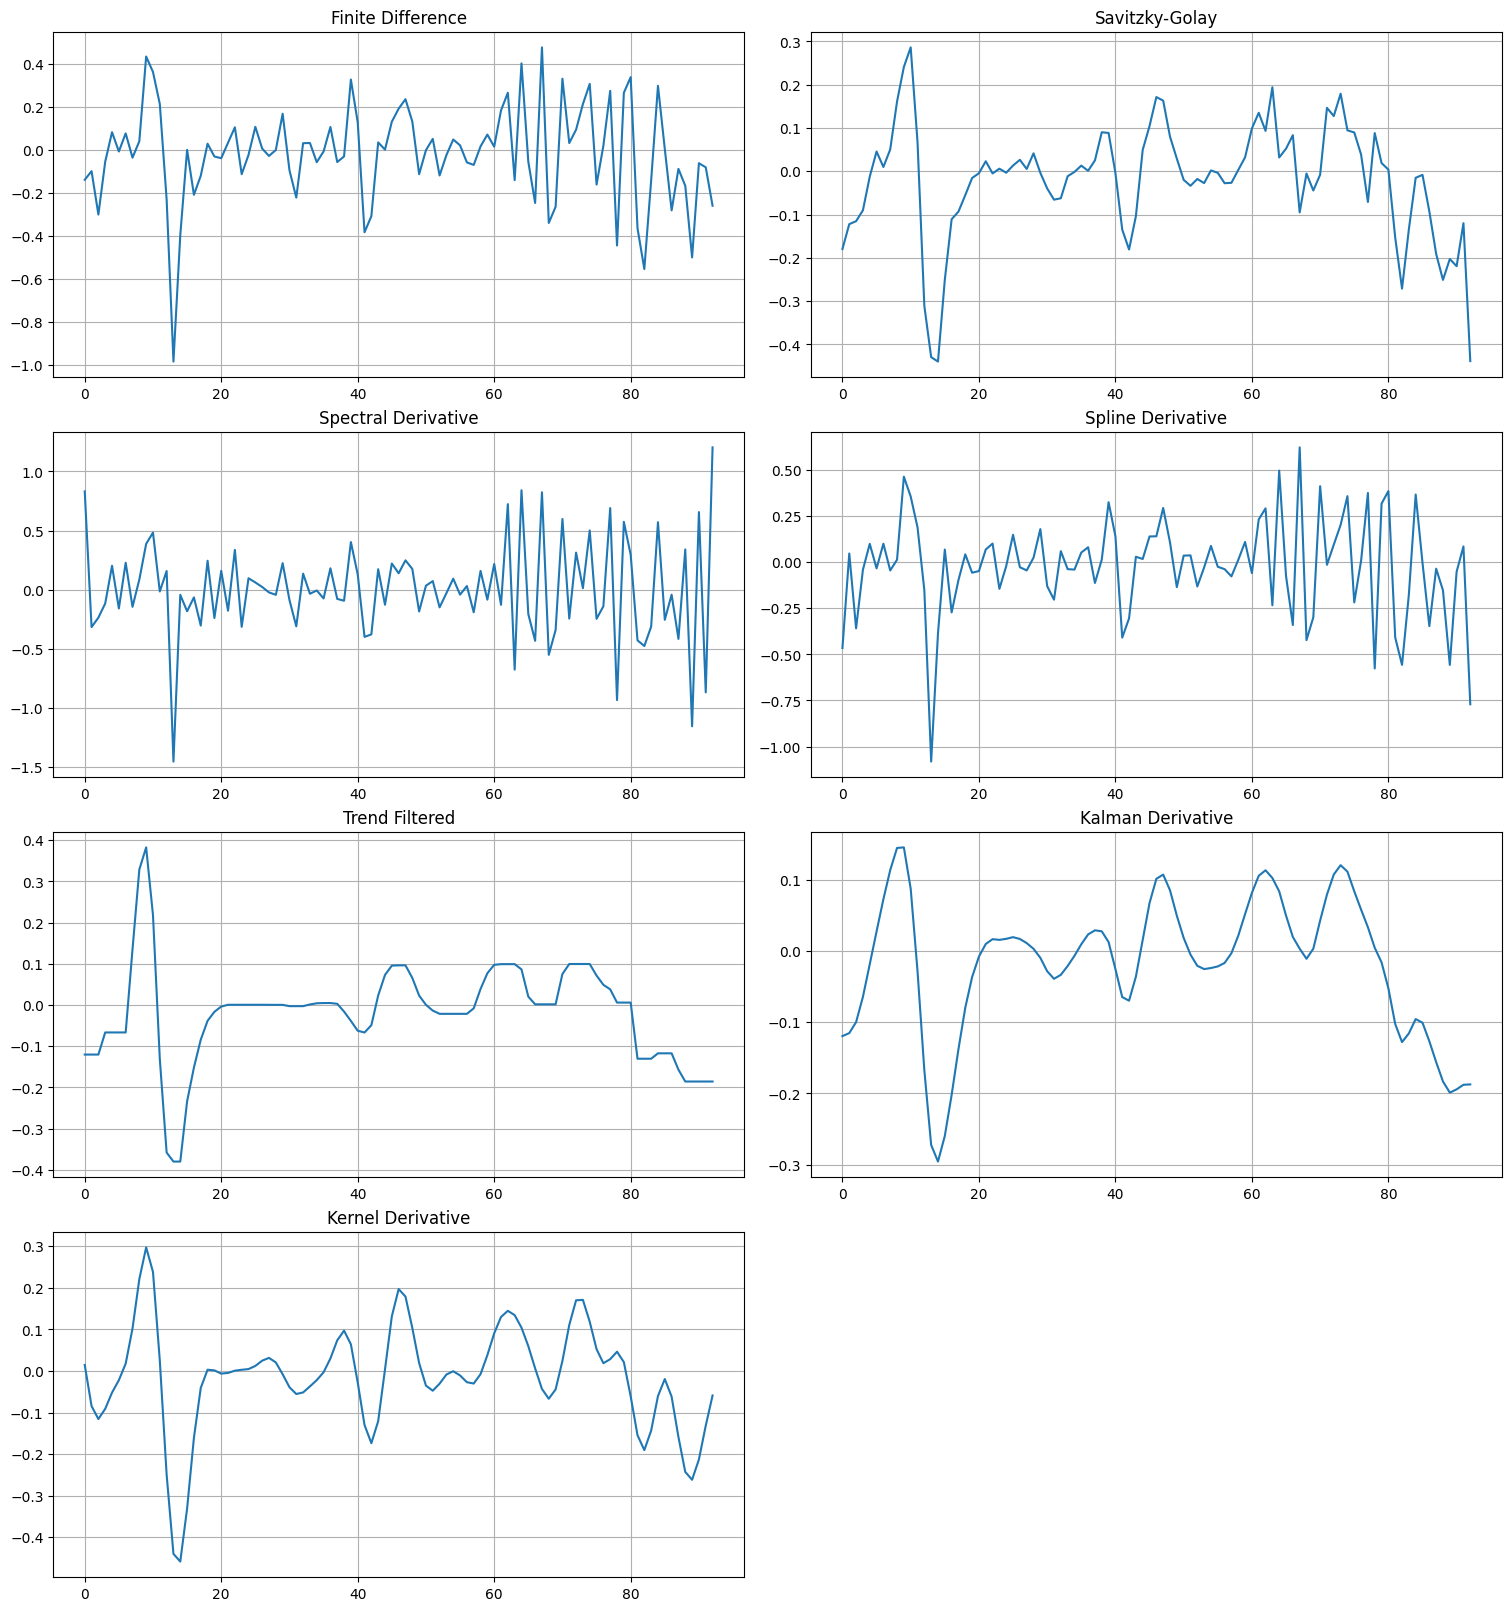

In [ ]:
x=np.array(test_IF_hist[2])
t = np.arange(len(x))/3

# Calculate derivatives using the provided methods
result1 = dxdt(x, t, kind="finite_difference", k=2)
result2 = dxdt(x, t, kind="savitzky_golay", left=2, right=2, order=2, iwindow=True)
result3 = dxdt(x, t, kind="spectral")
result4 = dxdt(x, t, kind="spline", s=1e-2)
result5 = dxdt(x, t, kind="trend_filtered", order=0, alpha=1e-2)
result6 = dxdt(x, t, kind="kalman", alpha=0.3)
result7 = dxdt(x, t, kind="kernel", sigma=1, lmbd=.1, kernel="rbf")

# Results and labels
results = [result1, result2, result3, result4, result5, result6, result7]
labels = [
    "Finite Difference", "Savitzky-Golay", "Spectral Derivative",
    "Spline Derivative", "Trend Filtered", "Kalman Derivative",
    "Kernel Derivative"
]

# Create subplots
fig, axes = plt.subplots(4, 2, figsize=(15, 16), constrained_layout=True)
axes = axes.flatten()

# Plot each result
for i, (result, label) in enumerate(zip(results, labels)):
    # axes[i].plot(t, x, label="Original Signal")
    axes[i].plot( result, label=f"{label} Derivative")
    axes[i].set_title(label)
    # axes[i].legend()
    axes[i].grid()

# Hide unused subplots
for j in range(len(results), len(axes)):
    axes[j].axis('off')

plt.show()

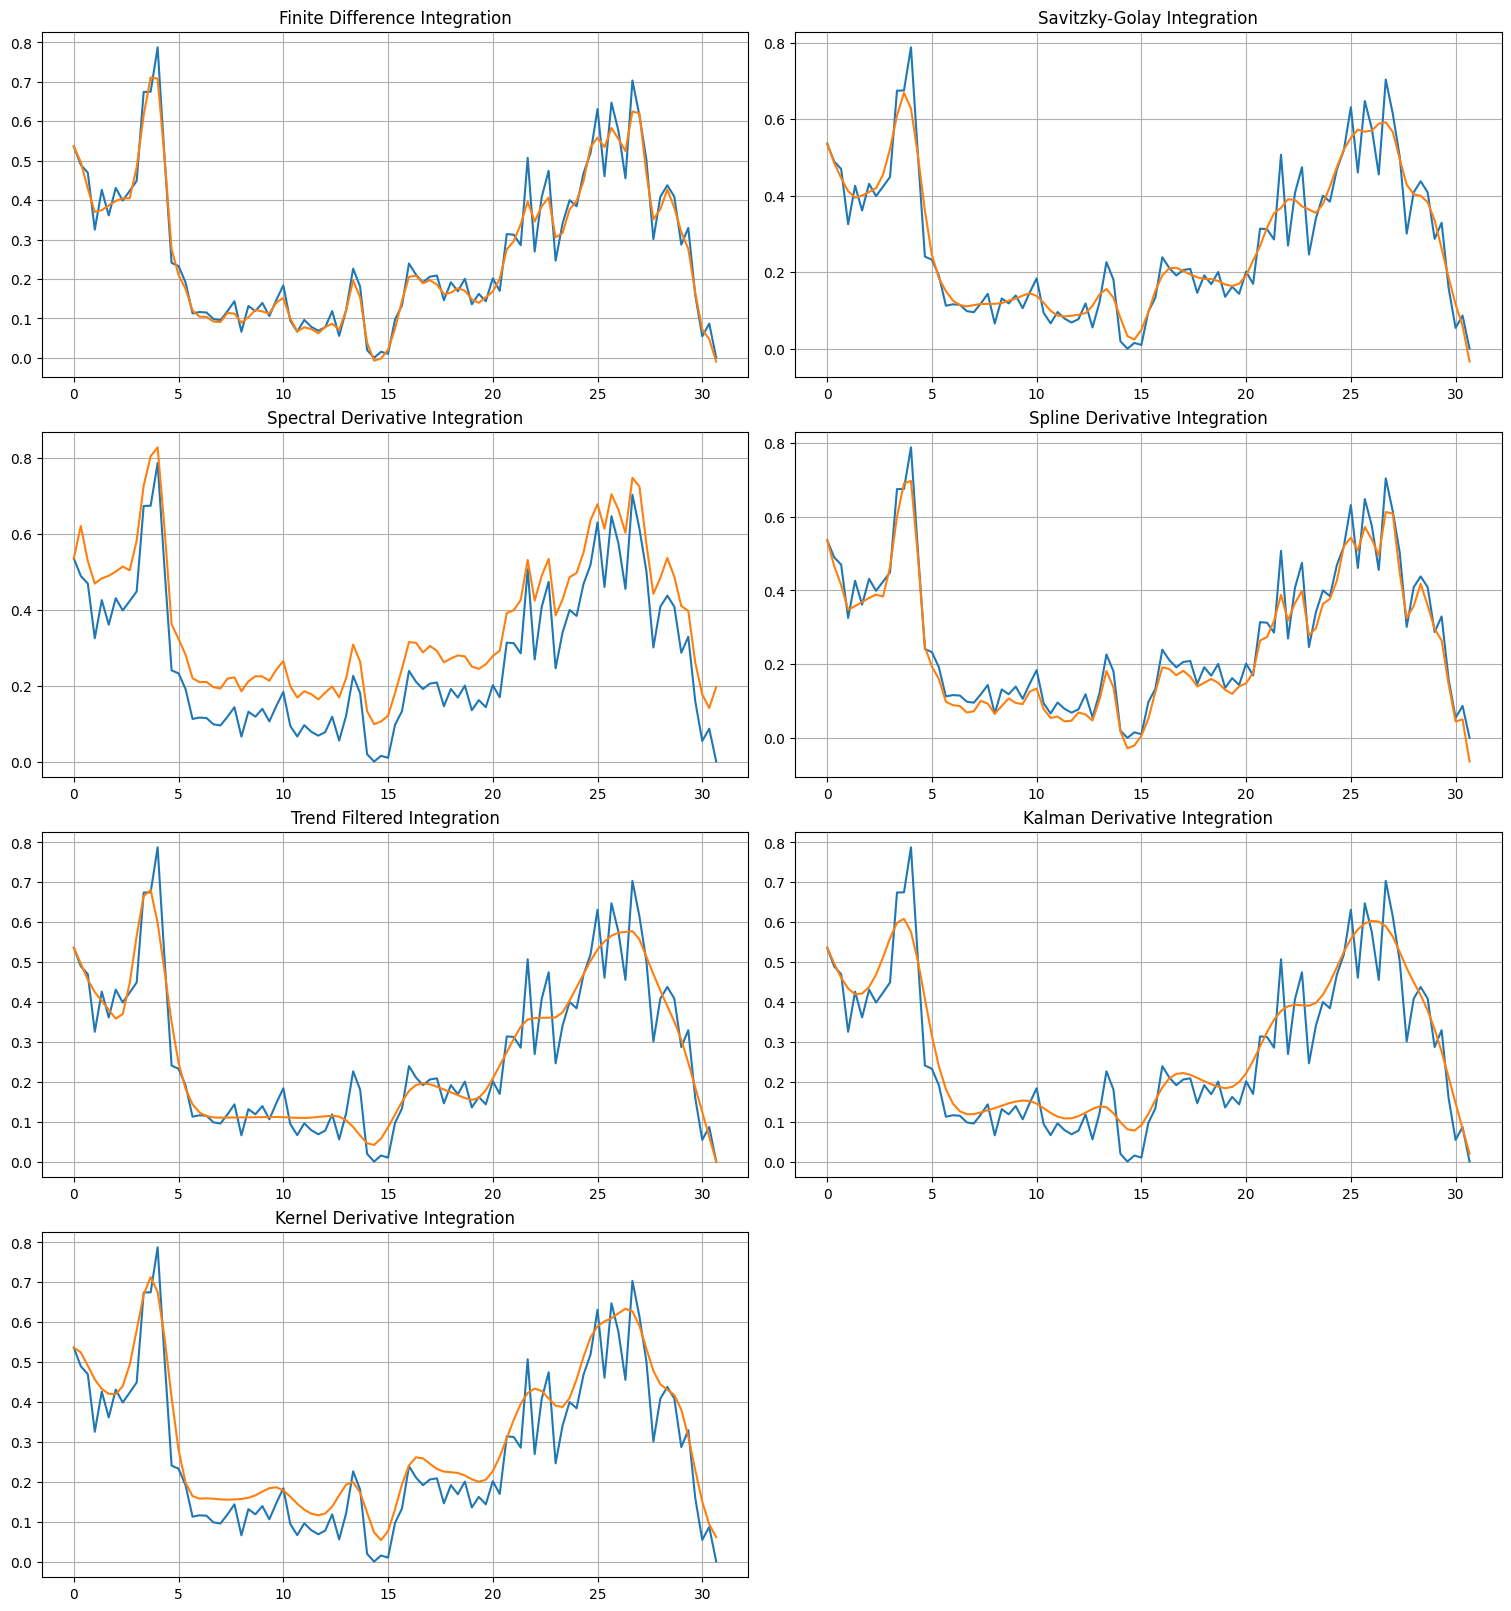

In [ ]:
from scipy.integrate import cumulative_trapezoid

# Integrate each result
integrated_results = [cumulative_trapezoid(result, t, initial=0) + x[0] for result in results]

# Create subplots for integrated results
fig, int_axes = plt.subplots(4, 2, figsize=(15, 16), constrained_layout=True)
int_axes = int_axes.flatten()

# Plot each integrated result
for i, (integrated_result, label) in enumerate(zip(integrated_results, labels)):
    int_axes[i].plot(t, x, label="Original Signal")
    int_axes[i].plot(t, integrated_result, label=f"{label} Integrated")
    int_axes[i].set_title(f"{label} Integration")
    # int_axes[i].legend()
    int_axes[i].grid()

# Hide unused subplots for integrated results
for j in range(len(integrated_results), len(int_axes)):
    int_axes[j].axis('off')

plt.show()

In [ ]:
len(result6)

93

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


def test_func_sns_2(test_df, funcs, func_labels=None):
    # Set seaborn style and context
    sns.set_theme(style="whitegrid", context="talk")

    num_subplots = len(test_df) * (len(funcs) + 1)
    fig, axes = plt.subplots(
        num_subplots, 1, figsize=(12, 3 * num_subplots), sharex=True
    )

    # Ensure axes is iterable (in case of a single subplot)
    if num_subplots == 1:
        axes = [axes]

    # Add a color palette for variety
    palette = sns.color_palette("husl", n_colors=len(funcs))
    idx = 0
    for row_idx, row in test_df.iterrows():
        data = row['ice_frac_hist']
        x_values = list(range(len(data)))  # Generate x-axis values

        # Plot original data
        ax_main = axes[idx * (len(funcs) + 1)]
        sns.lineplot(ax=ax_main, x=x_values, y=data, color='blue',
                     linewidth=2, label='Original Data')
        if 'label' in row.keys():
            label = row['label']
        else:
            label = ""
        ax_main.set_title(
            f"{label}", loc='center', fontsize=14, fontweight='bold')
        ax_main.legend(loc='upper right', fontsize=10)
        ax_main.set_ylim(0,1)
        ax_main.tick_params(axis='both', which='major', labelsize=10)
        ax_main.tick_params(axis='both', which='minor', labelsize=8)
        for func_idx, func in enumerate(funcs):
            filtered_hist, glaciations = func(row)
            ax_ind = idx * (len(funcs) + 1) + func_idx + 1

            # Plot filtered data
            sns.lineplot(
                ax=axes[ax_ind], x=x_values, y=filtered_hist,
                color=palette[func_idx], linewidth=2, label=f"Filtered: {func_labels[func_idx] if func_labels else f'Func {func_idx+1}'}"
            )
            axes[ax_ind].set_title(
                f"{func_labels[func_idx] if func_labels else f'Function {func_idx+1}'} Applied on {label}",
                loc='left', fontsize=12
            )
            axes[ax_ind].legend(loc='upper right', fontsize=10)
            axes[ax_ind].tick_params(axis='both', which='major', labelsize=10)
            axes[ax_ind].tick_params(axis='both', which='minor', labelsize=8)
            # ax[ax_ind].set_ylim(0,1)
            # Highlight glaciations and add magnitude annotations
            if glaciations:
                for glac in glaciations:
                    # Highlight region
                    axes[ax_ind].axvspan(
                        xmin=glac.min_ind, xmax=glac.max_ind, facecolor='green', alpha=0.3,
                        label='Glaciation Period' if 'Glaciation Period' not in axes[ax_ind].get_legend_handles_labels()[
                            1] else None
                    )

                    # Calculate the center of the glaciation region
                    center_x = (glac.min_ind + glac.max_ind) / 2
                    # Use max value in the region for vertical placement
                    center_y = max(filtered_hist) - \
                        (max(filtered_hist)-min(filtered_hist))*0.13

                    # # Add magnitude annotation
                    # axes[ax_ind].text(
                    #     center_x, center_y, f"ΔIF = {glac.magnitude:.2f}\nCGT = {glac.time/60} h",
                    #     fontsize=10, color='black', ha='center', va='bottom', fontweight='bold',
                    #     bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white', alpha=0.8)
                    # )
                    # Add magnitude annotation
                    axes[ax_ind].text(
                        center_x, center_y, f"ΔIF = {glac.magnitude:.2f}\nCGT = {glac.time/60} h",
                        fontsize=10, color='black', ha='center', va='bottom',
                        bbox=dict(boxstyle="round,pad=0.3",
                                  edgecolor='gray', facecolor='white', alpha=0.8)
                    )
            
            
        idx += 1
    
    # Add a common x-axis label
    fig.text(0.5, 0.02, "Time Steps", ha='center',
             fontsize=16, fontweight='bold')

    # Add a common y-axis label
    fig.text(0.02, 0.5, "Ice Fraction", va='center',
             rotation='vertical', fontsize=16, fontweight='bold')

    # Adjust layout to prevent overlaps
    # Leave space for shared labels
    # Set global font size for tick labels
    # plt.rc('xtick', labelsize=5)  # Adjust x-axis tick size
    # plt.rc('ytick', labelsize=5)  # Adjust y-axis tick size
    plt.setp(ax, ylim=(0,1))
    plt.tight_layout(rect=[0.03, 0.04, 1, 0.98])
    plt.savefig(os.path.join(GTE_DIR,"/Result_graphs/Glacitaiton_identified_test_cases.png"),dpi=400)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


def test_func_sns_short(test_df, funcs, func_labels=None):
    # Set seaborn style and context
    sns.set_theme(style="whitegrid", context="talk")

    num_subplots = len(test_df)
    fig, axes = plt.subplots(
        num_subplots, 1, figsize=(12, 3 * num_subplots), sharex=True
    )

    # Ensure axes is iterable (in case of a single subplot)
    if num_subplots == 1:
        axes = [axes]

    # Add a color palette for variety
    palette = sns.color_palette("husl", n_colors=len(funcs))
    idx = 0
    for row_idx, row in test_df.iterrows():
        data = row['ice_frac_hist']
        x_values = list(range(len(data)))  # Generate x-axis values

        # Plot original data
        ax_main = axes[idx]
        sns.lineplot(ax=ax_main, x=x_values, y=data, color='blue',
                     linewidth=1)
        if 'label' in row.keys():
            label = row['label']
        else:
            label = ""
        ax_main.set_title(
            f"{label}", fontsize=14)
        # ax_main.legend(loc='upper right', fontsize=10)
        ax_main.set_ylim(0,1)
        ax_main.tick_params(axis='both', which='major', labelsize=10)
        ax_main.tick_params(axis='both', which='minor', labelsize=8)
        filtered_hist, glaciations = select_peaks(row["ice_frac_hist"],filt=None)
        if glaciations:
                for glac in glaciations:
                    # Highlight region
                    ax_main.axvspan(
                        xmin=glac.min_ind, xmax=glac.max_ind, facecolor='green', alpha=0.3,
                        label='Glaciation Period' if 'Glaciation Period' not in ax_main.get_legend_handles_labels()[
                            1] else None
                    )

                    # Calculate the center of the glaciation region
                    center_x = (glac.min_ind + glac.max_ind) / 2
                    # Use max value in the region for vertical placement
                    center_y = max(filtered_hist) +0.05
                    ax_main.text(
                        center_x, center_y, f"ΔIF = {glac.magnitude:.2f}\nCGT = {glac.time/60} h",
                        fontsize=10, color='black', ha='center', va='bottom',
                        bbox=dict(boxstyle="round,pad=0.3",
                                  edgecolor='gray', facecolor='white', alpha=0.8)
                    )

            
            
            
        idx += 1
    
    # Add a common x-axis label
    fig.text(0.5, 0.02, "Time Steps", ha='center',
             fontsize=16, fontweight='bold')

    # Add a common y-axis label
    fig.text(0.02, 0.5, "Ice Fraction", va='center',
             rotation='vertical', fontsize=16, fontweight='bold')
    fig.suptitle('Glaciations detected (Threshold = 0.4)', fontsize=20, fontweight='bold')
    # Adjust layout to prevent overlaps
    # Leave space for shared labels
    # Set global font size for tick labels
    # plt.rc('xtick', labelsize=5)  # Adjust x-axis tick size
    # plt.rc('ytick', labelsize=5)  # Adjust y-axis tick size
    plt.setp(ax, ylim=(0,1))
    plt.tight_layout(rect=[0.03, 0.04, 1, 0.98])
    plt.savefig(os.path.join(GTE_DIR,"/Result_graphs/Glacitaiton_identified_test_cases_short.png"),dpi=400)

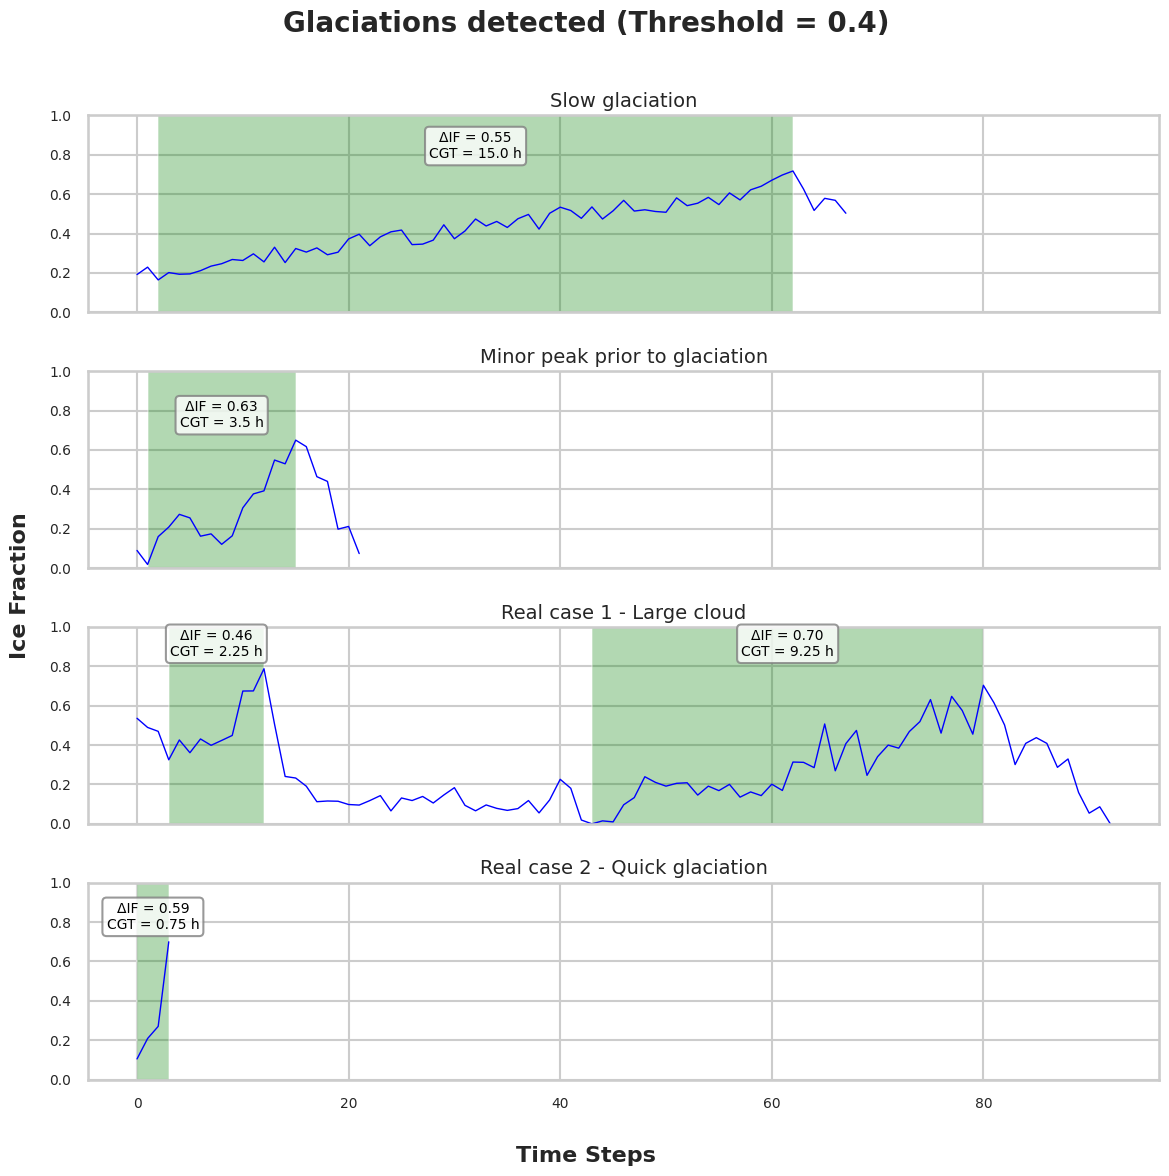

In [ ]:
from functools import partial


def filter_wrapper(data, filt):
    return filt(data), []


# test_filt_list = [partial(filter_wrapper, filt=noise_filter_3), partial(
#     filter_wrapper, filt=noise_filter_4)]
#func_labels = ["Window averaging", "Savitzky-Golay filter"]
# test_filt_list = [None, partial(select_peaks, filt=noise_filter_3), partial(select_peaks, filt=noise_filter_4)]
test_filt_list = [partial(select_peaks, filt=None)]
func_labels = ["Savitzky-Golay filter"]
test_func_sns_short(tests_df.iloc[:-1], test_filt_list)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


def test_func_sns_2(test_df, funcs, func_labels=None):
    # Set seaborn style and context
    sns.set_theme(style="whitegrid", context="talk")

    num_subplots = len(test_df) * (len(funcs) + 1)
    fig, axes = plt.subplots(
        num_subplots, 1, figsize=(12, 3 * num_subplots), sharex=True
    )

    # Ensure axes is iterable (in case of a single subplot)
    if num_subplots == 1:
        axes = [axes]

    # Add a color palette for variety
    palette = sns.color_palette("husl", n_colors=len(funcs))
    idx = 0
    for row_idx, row in test_df.iterrows():
        data = row['ice_frac_hist']
        x_values = list(range(len(data)))  # Generate x-axis values

        # Plot original data
        ax_main = axes[idx * (len(funcs) + 1)]
        sns.lineplot(ax=ax_main, x=x_values, y=data, color='blue',
                     linewidth=2, label='Original Data')
        if 'label' in row.keys():
            label = row['label']
        else:
            label = ""
        ax_main.set_title(
            f"{label}", loc='center', fontsize=14, fontweight='bold')
        ax_main.legend(loc='upper right', fontsize=10)
        ax_main.set_ylim(0,1)
        ax_main.tick_params(axis='both', which='major', labelsize=10)
        ax_main.tick_params(axis='both', which='minor', labelsize=8)
        for func_idx, func in enumerate(funcs):
            filtered_hist, glaciations = func(row)
            ax_ind = idx * (len(funcs) + 1) + func_idx + 1

            # Plot filtered data
            sns.lineplot(
                ax=axes[ax_ind], x=x_values, y=filtered_hist,
                color=palette[func_idx], linewidth=2, label=f"Filtered: {func_labels[func_idx] if func_labels else f'Func {func_idx+1}'}"
            )
            axes[ax_ind].set_title(
                f"{func_labels[func_idx] if func_labels else f'Function {func_idx+1}'} Applied on {label}",
                loc='left', fontsize=12
            )
            axes[ax_ind].legend(loc='upper right', fontsize=10)
            axes[ax_ind].tick_params(axis='both', which='major', labelsize=10)
            axes[ax_ind].tick_params(axis='both', which='minor', labelsize=8)
            # ax[ax_ind].set_ylim(0,1)
            # Highlight glaciations and add magnitude annotations
            if glaciations:
                for glac in glaciations:
                    # Highlight region
                    axes[ax_ind].axvspan(
                        xmin=glac.min_ind, xmax=glac.max_ind, facecolor='green', alpha=0.3,
                        label='Glaciation Period' if 'Glaciation Period' not in axes[ax_ind].get_legend_handles_labels()[
                            1] else None
                    )

                    # Calculate the center of the glaciation region
                    center_x = (glac.min_ind + glac.max_ind) / 2
                    # Use max value in the region for vertical placement
                    center_y = max(filtered_hist) - \
                        (max(filtered_hist)-min(filtered_hist))*0.13

                    # # Add magnitude annotation
                    # axes[ax_ind].text(
                    #     center_x, center_y, f"ΔIF = {glac.magnitude:.2f}\nCGT = {glac.time/60} h",
                    #     fontsize=10, color='black', ha='center', va='bottom', fontweight='bold',
                    #     bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white', alpha=0.8)
                    # )
                    # Add magnitude annotation
                    axes[ax_ind].text(
                        center_x, center_y, f"ΔIF = {glac.magnitude:.2f}\nCGT = {glac.time/60} h",
                        fontsize=10, color='black', ha='center', va='bottom',
                        bbox=dict(boxstyle="round,pad=0.3",
                                  edgecolor='gray', facecolor='white', alpha=0.8)
                    )
            
            
        idx += 1
    
    # Add a common x-axis label
    fig.text(0.5, 0.02, "Time Steps", ha='center',
             fontsize=16, fontweight='bold')

    # Add a common y-axis label
    fig.text(0.02, 0.5, "Ice Fraction", va='center',
             rotation='vertical', fontsize=16, fontweight='bold')

    # Adjust layout to prevent overlaps
    # Leave space for shared labels
    # Set global font size for tick labels
    # plt.rc('xtick', labelsize=5)  # Adjust x-axis tick size
    # plt.rc('ytick', labelsize=5)  # Adjust y-axis tick size
    plt.setp(ax, ylim=(0,1))
    plt.tight_layout(rect=[0.03, 0.04, 1, 0.98])
    plt.savefig(os.path.join(GTE_DIR,"/Result_graphs/Glacitaiton_identified_test_cases.png"),dpi=400)

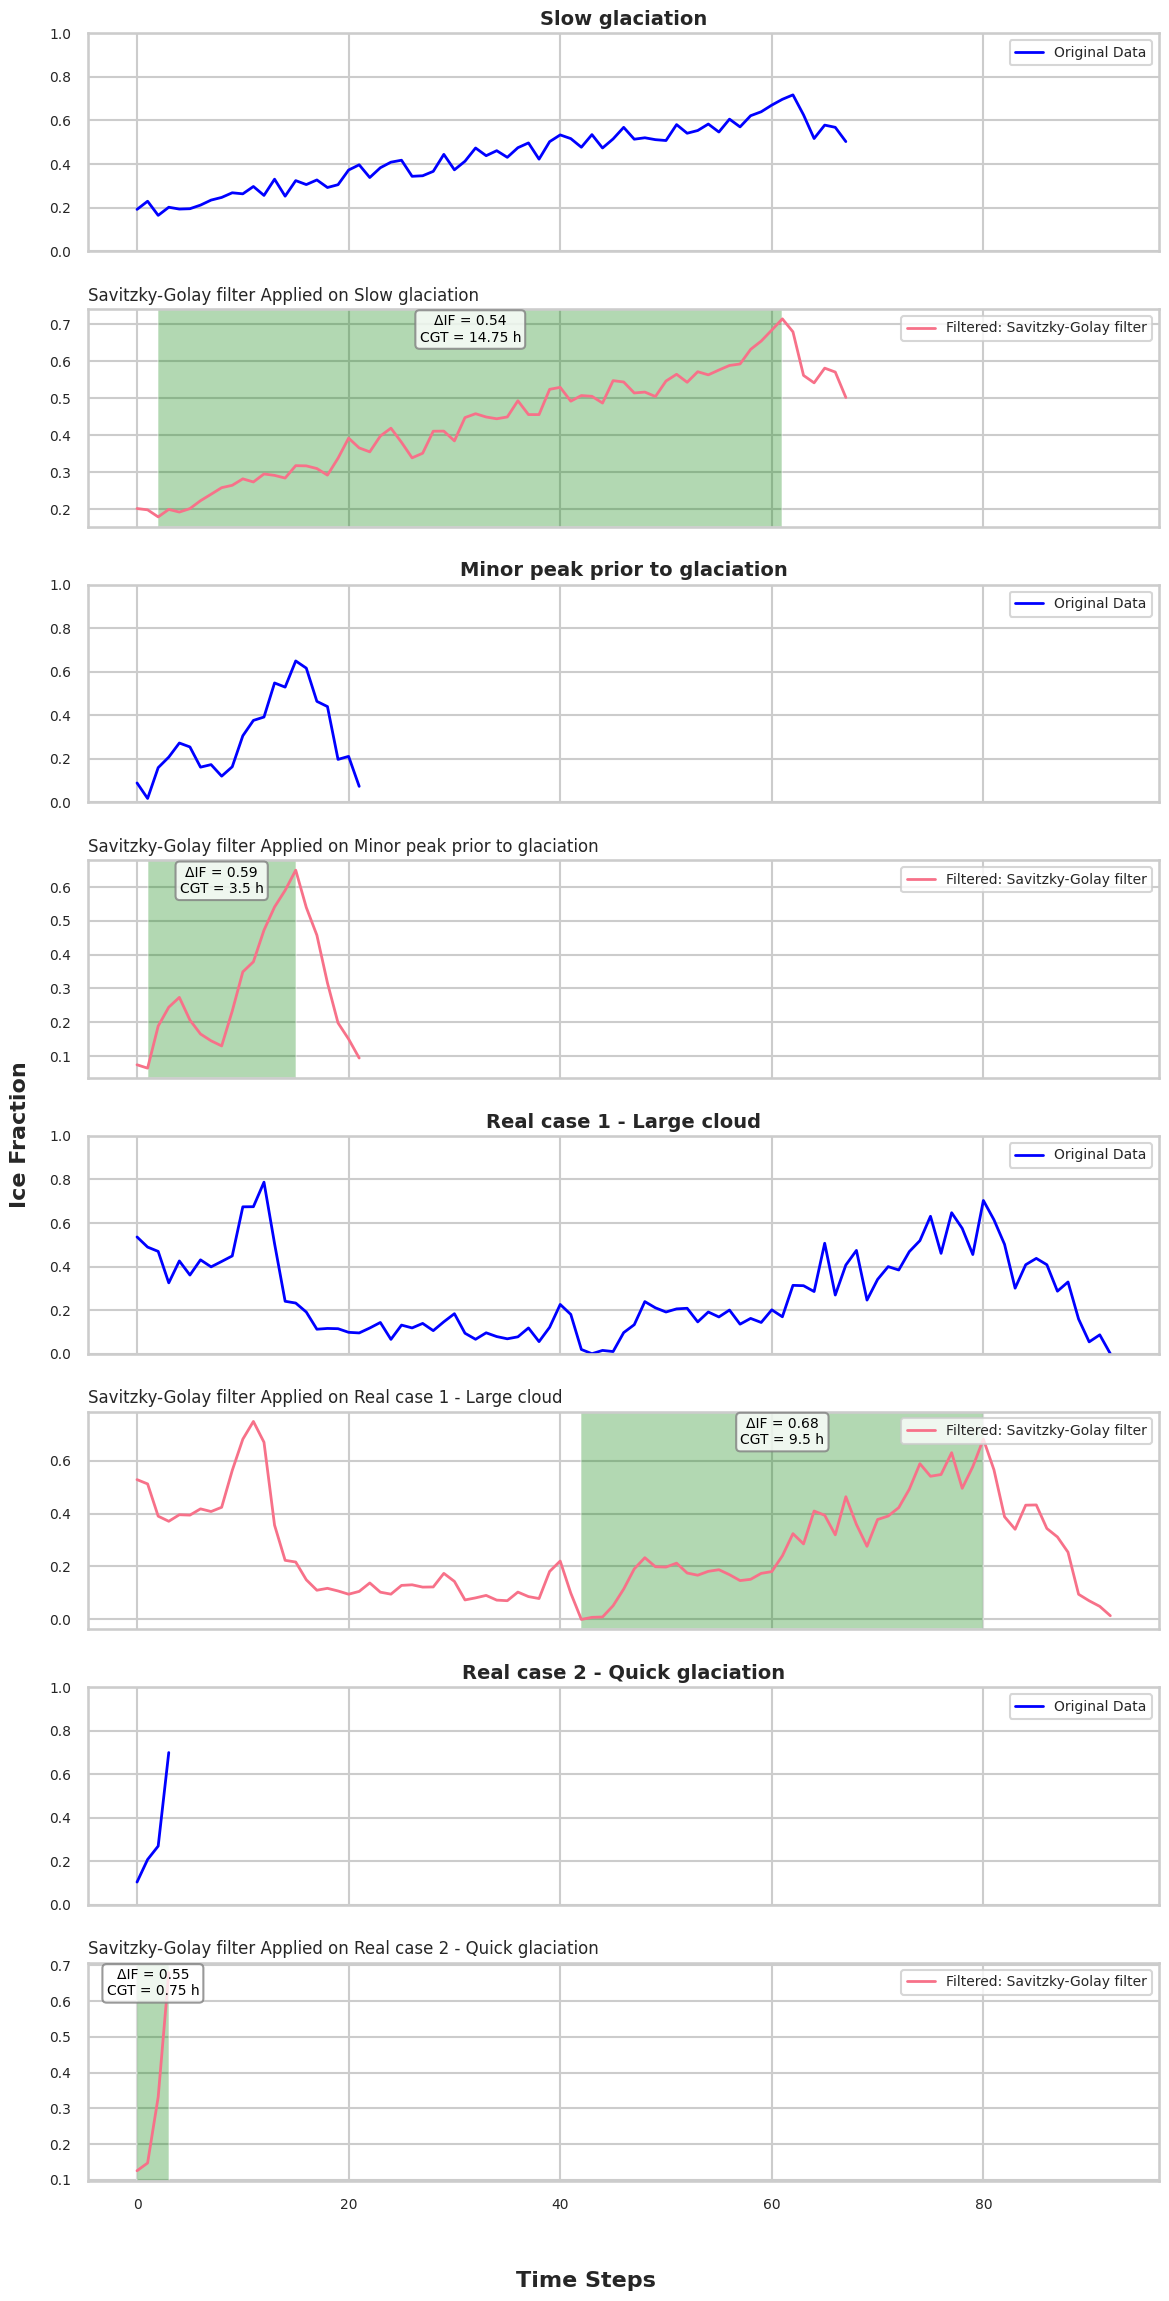

In [ ]:
from functools import partial


def filter_wrapper(data, filt):
    return filt(data), []


# test_filt_list = [partial(filter_wrapper, filt=noise_filter_3), partial(
#     filter_wrapper, filt=noise_filter_4)]
#func_labels = ["Window averaging", "Savitzky-Golay filter"]
# test_filt_list = [None, partial(select_peaks, filt=noise_filter_3), partial(select_peaks, filt=noise_filter_4)]
test_filt_list = [partial(select_peaks, filt=noise_filter_4)]
func_labels = ["Savitzky-Golay filter"]
test_func_sns_2(tests_df.iloc[:-1], test_filt_list, func_labels=func_labels)
# plt.savefig

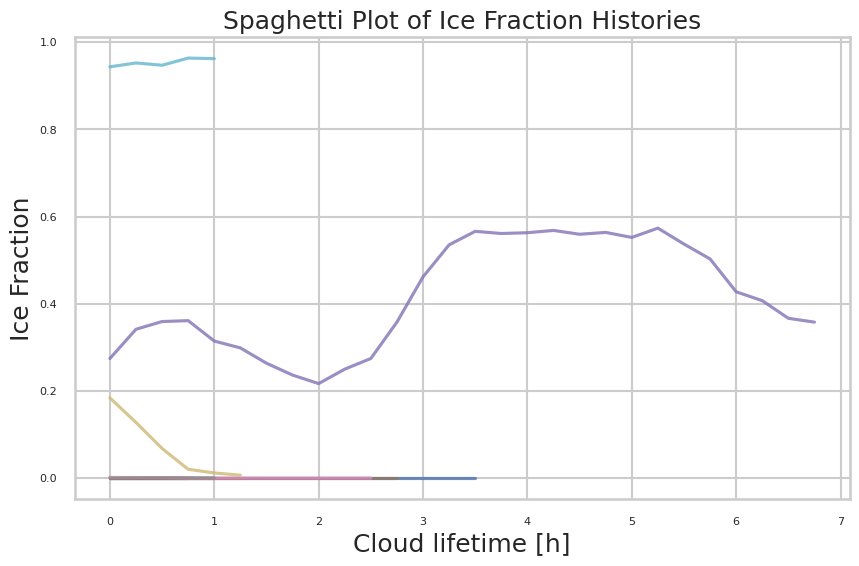

In [ ]:

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Loop through each row and plot the lists in 'ice_frac_hist'
for i, row in sample_df_2.iterrows():
    ice_frac_hist = row['ice_frac_hist']
    # Add alpha for transparency to better visualize overlaps
    plt.plot(np.arange(len(ice_frac_hist))*0.25,
             noise_filter_3(row), alpha=0.8)

# Add labels and title
plt.xlabel('Cloud lifetime [h]')
plt.ylabel('Ice Fraction')
plt.title('Spaghetti Plot of Ice Fraction Histories')
# plt.xlim(0,5)
# Show the plot
plt.show()

In [ ]:
# sample_df_2


In [ ]:
def find_glaciation(samples, delta_thresh=0.2):
    assert len(samples) >= 4
    "At least 4 samples needed"
    running_min = 1
    glac_ind = 0
    # Set
    min_ind_list = []
    glac_trigger_ind_list = []
    max_ind_list = []
    glac_trigger = False

    for idx, samp in enumerate(samples, 1):
        threshold = running_min+delta_thresh

        if not glac_trigger:
            if samp < running_min:
                running_min = samp
                min_ind = idx
                print(idx, samp, threshold, samples[idx-1])
            if samp >= threshold:
                if abs(samp - samples[idx-1]) > 1e-3:
                    glac_trigger_ind = idx - \
                        (samp-threshold)/(samp-samples[idx-1])
                else:
                    glac_trigger_ind = idx
                return min_ind, glac_trigger_ind, threshold
                # glac_trigger=True

        # else:

In [ ]:
small_bell_curve = gen_bell_curve(mean, std_dev, n_bell_points)
small_bell_curve = small_bell_curve[:-int(n_bell_points/4)]
big_bell_curve = gen_bell_curve(mean, std_dev*2, n_bell_points*2)*5
big_bell_curve = big_bell_curve[big_bell_curve > small_bell_curve[-1]]
combined_curve = list(np.concatenate((small_bell_curve + 0.1,
                      big_bell_curve+0.1, small_bell_curve, small_bell_curve - 0.1)))

In [ ]:
tests_df.loc[4] = [combined_curve, "many_peaks"]
tests_df.loc[4]

ice_frac_hist    [0.102215924205969, 0.11311094454685475, 0.149...
label                                                   many_peaks
Name: 4, dtype: object

In [ ]:
filtered_hist, _ = test_filt_list[0](tests_df.loc[4])
idxtopeak, res = get_persistent_homology(filtered_hist)

IndexError: list index out of range

In [ ]:
print(res)


In [ ]:
meas = noise_filter_3(tests_df.iloc[2])  # test_IF_hist[2])
sp = np.fft.fft(meas)
fs = 1/(2*15)
trange = np.linspace(0, fs, len(meas))
plt.plot(trange, np.abs(sp))
plt.show()

In [ ]:
# Normalize the color values to [0, 1]
normalized_res = (np.array(idxtopeak) - min(idxtopeak)) / \
    (max(idxtopeak) - min(idxtopeak))

# Create a color map
# You can choose other colormaps like 'plasma', 'coolwarm', etc.
cmap = plt.cm.viridis

# Plot each segment with a different color
for i in range(len(filtered_hist) - 1):
    plt.plot(
        [i, i + 1],
        [filtered_hist[i], filtered_hist[i + 1]],
        color=cmap(normalized_res[i])
    )

# Add a colorbar to show the scale of `res`
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(
    vmin=min(idxtopeak), vmax=max(idxtopeak)))
plt.colorbar(sm, label="Value of res")

plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Filtered Histogram with Color-Coded Segments")
plt.show()

In [ ]:
plt.plot(filtered_hist)
born_ind = [peak.born for peak in res]
left_ind = [peak.left for peak in res]
right_ind = [peak.right for peak in res]
died_ind = [peak.died for peak in res]
plt.scatter(born_ind, [filtered_hist[ind] for ind in born_ind], color='red')
plt.scatter(left_ind, [filtered_hist[ind] for ind in left_ind], color='green')
plt.scatter(right_ind, [filtered_hist[ind] for ind in right_ind], color='blue')

# Annotate each scatter point with the persistence value
for peak in res:
    persistence_value = peak.get_persistence(filtered_hist)
    x_coord = peak.born
    y_coord = filtered_hist[x_coord]
    plt.text(x_coord, y_coord, f'{persistence_value:.2f}',
             fontsize=8, color='blue', ha='right')

plt.show()

In [ ]:
print(born_ind, left_ind, right_ind, died_ind)

In [ ]:
# 229152
# 195006
min_ind, glac_trigger_ind, threshold = find_glaciation(
    test_sample['ice_frac_hist'])
print(min_ind, glac_trigger_ind)
plt.plot(test_sample['ice_frac_hist'])
plt.plot(min_ind, test_sample['ice_frac_hist'][min_ind], 'ro')
plt.hlines(threshold, 0, 20, alpha=0.3, color='gray')
plt.plot(int(glac_trigger_ind),
         test_sample['ice_frac_hist'][int(glac_trigger_ind)], 'ro')
plt.xlim(0, 20)